In [1]:
import time

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

In [2]:
hidden_size = 50
train_bound = 2
test_bound = 2

epochs = 100
learning_rate = 0.001
batch_size = 50

training_size = 1000
testing_size = 100

Epoch 0, Loss: 1935.102539
Epoch 10, Loss: 455.918335
Epoch 20, Loss: 1181.973999
Epoch 30, Loss: 130.459778
Epoch 40, Loss: 742.312073
Epoch 50, Loss: 69.025429
Epoch 60, Loss: 34.663219
Epoch 70, Loss: 47.477005
Epoch 80, Loss: 17.040501
Epoch 90, Loss: 13.747625


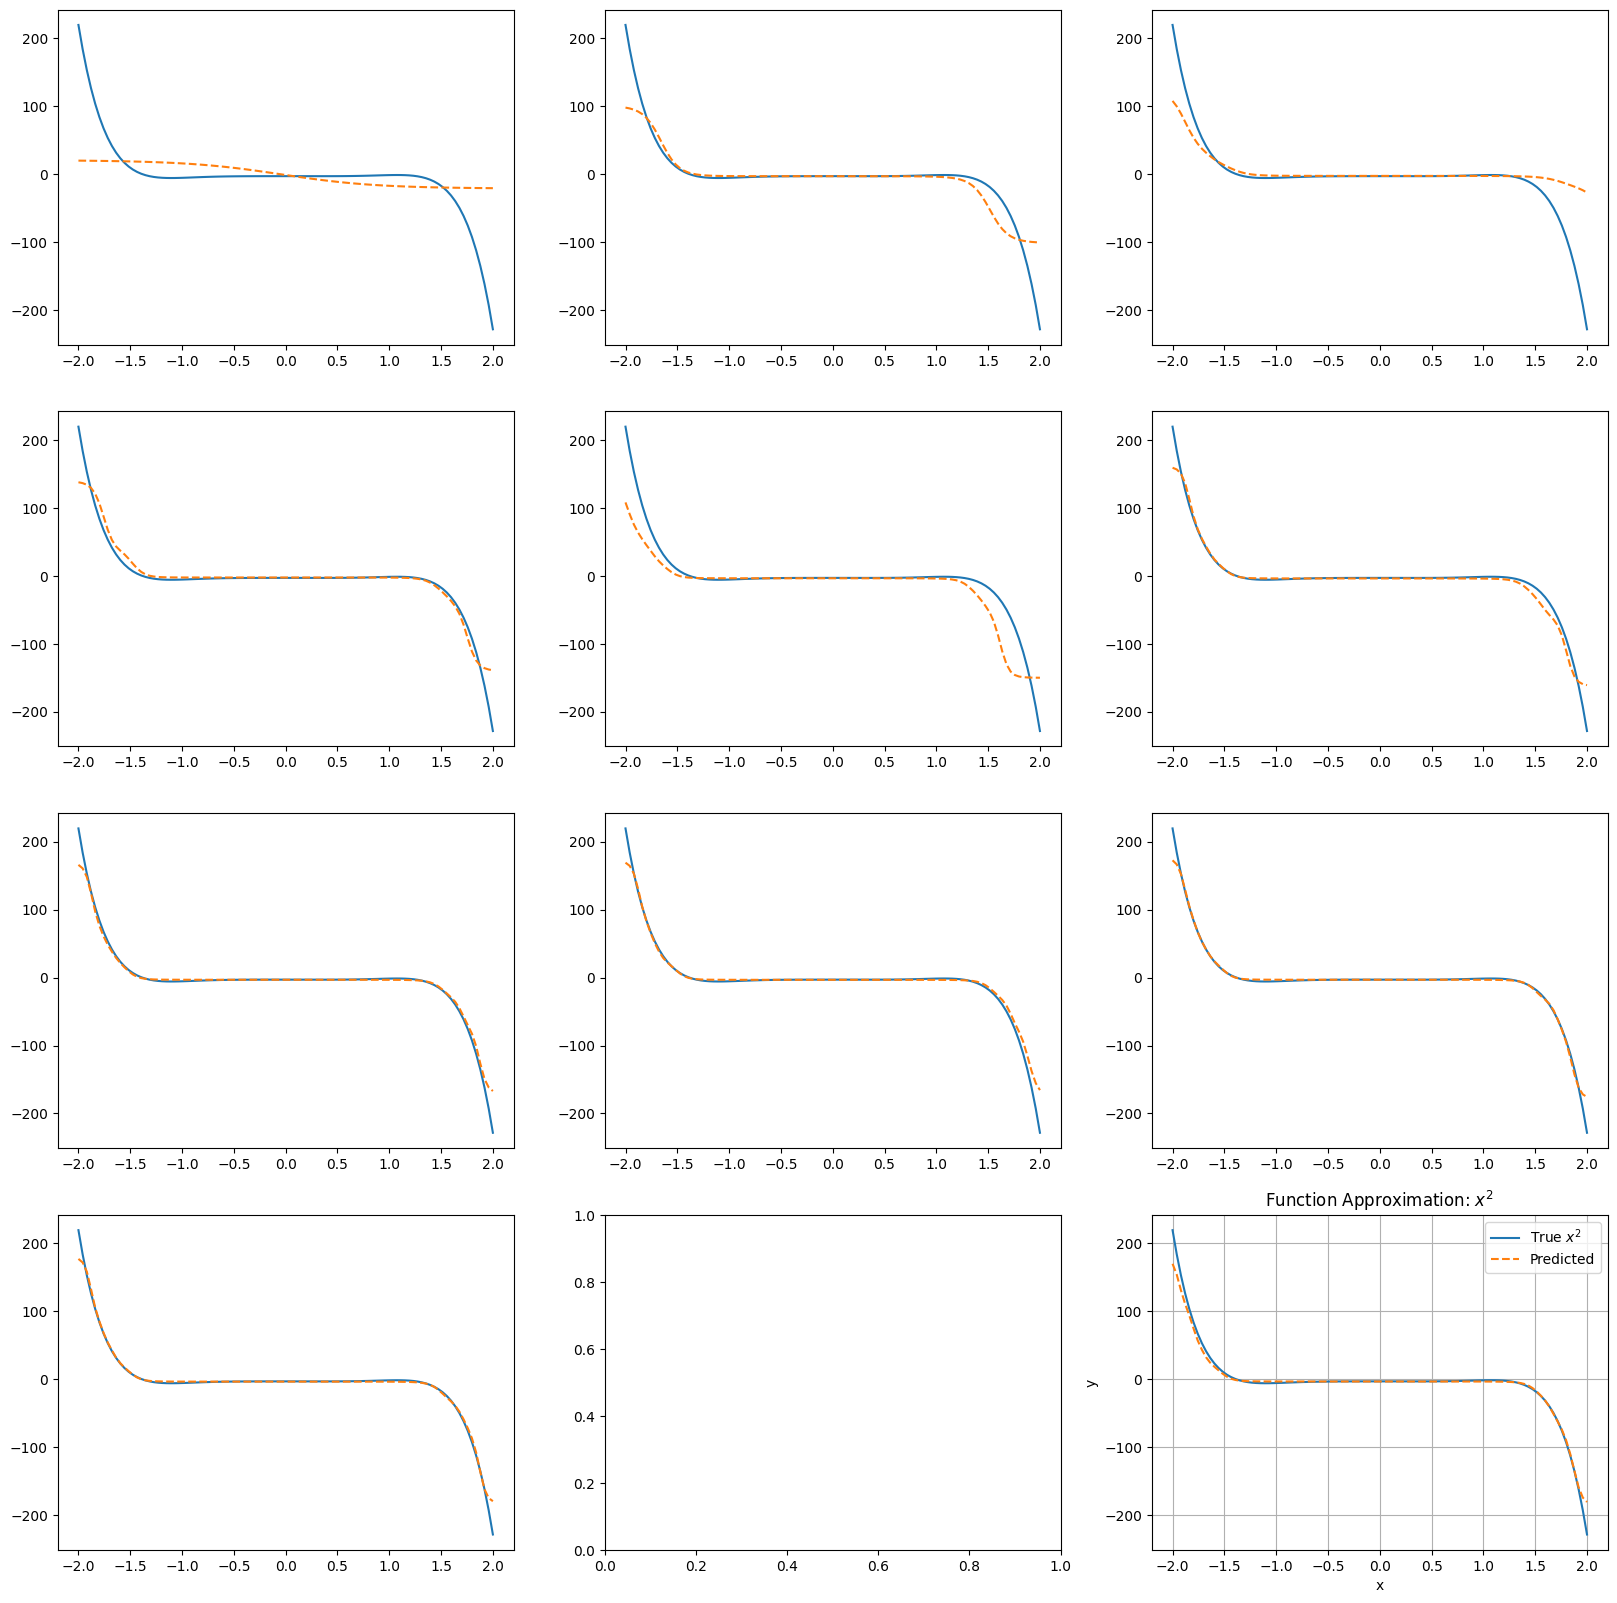

In [3]:

# 1. Define the model
class SquareApproximator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def __call__(self, x):
        return self.net(x)
    
def f(x):
    return 5 * x ** 5 - 3 * x ** 7 + np.cos(x) - 4

# 2. Generate training data
np.random.seed(42)
x_train = np.random.uniform(-train_bound, train_bound, (training_size, 1)).astype(np.float32)
y_train = f(x_train).astype(np.float32)

x_train_mx = mx.array(x_train)
y_train_mx = mx.array(y_train)

# 3. Initialize model and optimizer
model = SquareApproximator()

def loss_fn(model, X, y):
    return nn.losses.mse_loss(model(X), y, reduction="mean")

@partial(mx.compile, inputs=model.state, outputs=model.state)
def step(X, y):
    loss, grads = loss_and_grad_fn(model, X, y)
    optimizer.update(model, grads)
    return loss

optimizer = optim.SGD(learning_rate=learning_rate)
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

# 5. Evaluate and plot
x_test = np.linspace(-test_bound, test_bound, testing_size).reshape(-1, 1).astype(np.float32)
x_test_mx = mx.array(x_test)

fig, axs = plt.subplots(len(x_train) // batch_size // 2 // 3 + 1, 3, figsize=(20, 20));

i = 0

# 4. Training loop
for epoch in range(epochs):

    tic = time.perf_counter()
    
    for b in range(len(x_train) // batch_size):
        x_iter = x_train_mx[mx.random.randint(0,training_size,[batch_size])]
        y_iter = f(x_iter)

        step(x_iter, y_iter)
        mx.eval(model.state)
    
    loss_value = loss_fn(model, x_train_mx, y_train_mx)

    toc = time.perf_counter()
    
    if epoch % 10 == 0:

        print(f"Epoch {epoch}, Loss: {loss_value.item():.6f}")

        y_pred = model(x_test_mx)

        axs[i // 3, i - 3 * (i // 3)].plot(x_test, f(x_test), label="True $x^2$")
        axs[i // 3, i - 3 * (i // 3)].plot(x_test, y_pred, label="Predicted", linestyle="dashed")

        i+=1


# 5. Evaluate and plot
x_test = np.linspace(-2, 2, 100).reshape(-1, 1).astype(np.float32)
x_test_mx = mx.array(x_test)
y_pred = model(x_test_mx)

plt.plot(x_test, f(x_test), label="True $x^2$")
plt.plot(x_test, y_pred, label="Predicted", linestyle="dashed")
plt.legend()
plt.title("Function Approximation: $x^2$")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


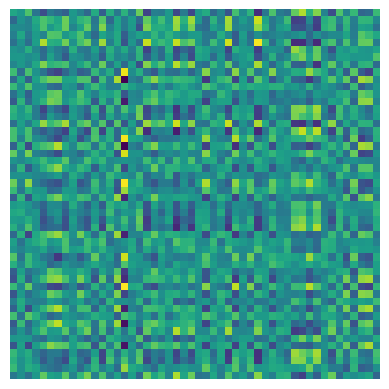

In [4]:
import numpy as np
np_img = np.array(model.parameters()['net']['layers'][2]['weight'])
plt.imshow(np_img)
plt.axis('off')
plt.show()